# Superstition

Superstition is a strategy that blindly trusts analyst's estinmates and recommendations.

In [69]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None
np.seterr(divide="ignore", invalid="ignore")
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="notebook", style="whitegrid", color_codes=True)
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")
from build import build_features
from build import build_labels
from build import build_train_test
from backtest import backtest_report

In [70]:
def superstition(df):
    df.dropna(how="all", subset=["numest", "suescore", "medrec"], inplace=True)
    df.eval(
        """
        diff_high = (prccd - ptghigh) / prccd
        diff_med = (prccd - medptg) / prccd
        diff_low = (prccd - ptglow) / prccd
        """,
        inplace=True,
    )
    return df.loc[
        (raw.mcap > 1e6) & (df.prccd > 5),
        ["numest",
        "numdown1m",
        "numup1m",
        "diff_high",
        "diff_med",
        "diff_low",
        "suescore",
        "medrec",
        "numdown",
        "numup",
        "numrec",
        "buypct",
        "holdpct",
        "sellpct",
        ],
    ]

In [71]:
# select stocks with market cap > 1 million, trading price > 5 as stock universe
raw = pd.read_parquet("../data/train-beta.1.parquet")
gvkeys = raw[(raw.mcap > 1e6) & (raw.prccd > 5)].index.get_level_values("gvkey").unique()
universe = raw.loc[gvkeys]

In [72]:
features = build_features(universe, superstition, scale="rank")

In [73]:
labels = build_labels(universe, months=3, relative=True)

In [74]:
X_train, y_train, X_test, y_test = build_train_test(
    features,
    labels,
    train_start="2002-01-01",
    train_end="2010-01-01",
    test_start="2010-01-01",
    test_end="2016-01-01",
    method="multi",
    thres=0.1, 
    extreme=True,
    lower=0.2,
    upper=0.8)

Classification report on training set:

              precision    recall  f1-score   support

          -1       0.59      0.55      0.57     16404
           0       0.72      0.02      0.05      2730
           1       0.57      0.70      0.63     17106

    accuracy                           0.58     36240
   macro avg       0.63      0.42      0.42     36240
weighted avg       0.59      0.58      0.56     36240

Classification report on test set:

              precision    recall  f1-score   support

          -1       0.20      0.46      0.28     10582
           0       0.67      0.00      0.00     38233
           1       0.21      0.63      0.31     12234

    accuracy                           0.21     61049
   macro avg       0.36      0.36      0.20     61049
weighted avg       0.49      0.21      0.11     61049



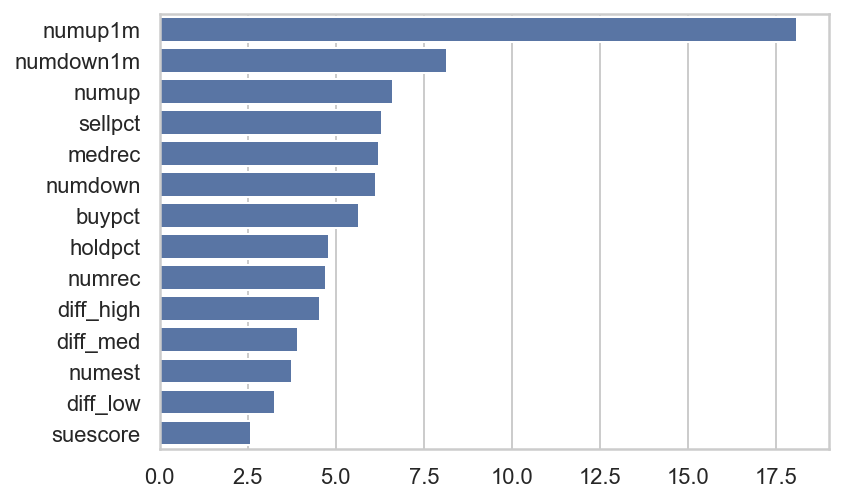

In [78]:
xgb_clf = XGBClassifier(n_estimators=100, max_depth=3, eval_metric="logloss", n_jobs=-1)
xgb_fit = xgb_clf.fit(X_train, y_train)
importance = pd.Series(data=xgb_clf.get_booster().get_score(importance_type="gain")).sort_values(ascending=False)
ax = sns.barplot(x=importance, y=importance.index, color="b")
print(f"Classification report on training set:\n")
print(classification_report(y_train, xgb_clf.predict(X_train)))
print(f"Classification report on test set:\n")
print(classification_report(y_test, xgb_clf.predict(X_test)))

In [76]:
data=pd.read_parquet("../data/backtest-beta.1.parquet")

Short positon sharpe ratio: 0.2675748425321785
Neutral positon sharpe ratio: 1.0573560853805384
Long positon sharpe ratio: 0.46589359960575705


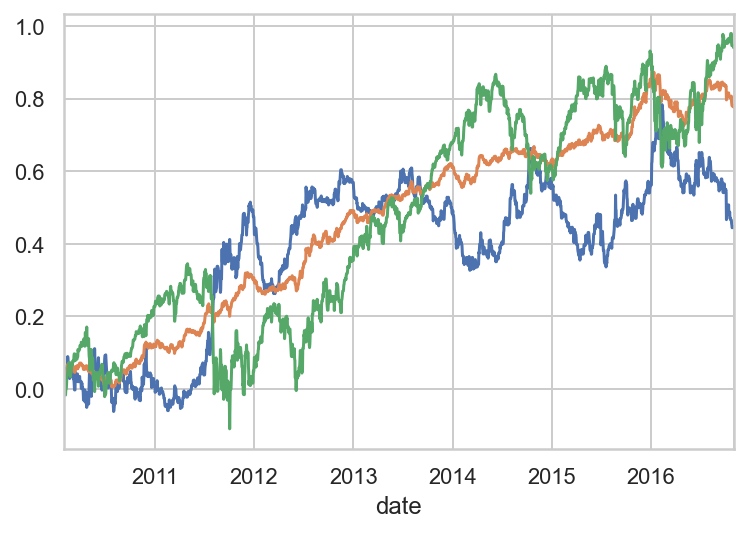

In [79]:
backtest_report(
    data,
    features,
    xgb_clf,
    test_start="2010-01-01",
    test_end="2016-01-01",
    months=3,
    n=10,
    weight="equal")